In [1]:
from os.path import join
from os.path import abspath
import itertools

import numpy as np
import pandas as pd
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure
from causalnex.network import BayesianNetwork
from causalnex.evaluation import classification_report, roc_auc
from sklearn.model_selection import KFold

from data_utils import read_reddit_data, read_covid, reformat_dataframe, add_missing_countries
from sentiment import add_lang, add_sentiment
from train_utils import discretize_df
from train import train_bn
from feature_extraction import get_feature_matrix
from inference import marginal_probs
from eval_utils import save_logs
from configs import config as cf

In [2]:
infected = reformat_dataframe(read_covid(cf.INFECTED_PATH))
deaths = reformat_dataframe(read_covid(cf.DEATHS_PATH))
infected.head(5)

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,3,4,5,6,7,8,11,16,20,22
Albania,0,0,0,0,0,0,0,0,0,0,...,1,4,8,15,23,31,38,44,49,55
Algeria,0,0,0,0,0,0,0,0,0,0,...,19,20,20,21,23,29,37,46,54,63
Andorra,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,14,27
Angola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
posts = read_reddit_data(cf.REDDIT_DATA_PATH)

#No need to run again, as the data loaded has been saved after adding sentiments

# add_missing_countries(posts) # add country info if missing (inplace)
# posts = add_lang(posts)
# posts = add_sentiment(posts)

# posts.head(5)

In [4]:
def country_full(row):
    
    if str(row["Country"]) == "NZ"  :
        return "New Zealand"
    elif  str(row["Country"]) == "UK":
        return "United Kingdom"    
    elif str(row["Country"]) == "AU" :
        return "Australia"
    elif str(row["Country"]) == "JP" :
        return "Japan"
    elif str(row["Country"]) == "BR" :
        return "Brazil"
    elif str(row["Country"]) == "CA"   :
        return "Canada"
    elif  str(row["Country"]) == "US":
        return "US"


posts['Location'] = posts.apply(lambda row: country_full(row), axis=1)

### Groupby days

In [5]:
# calculate daily counts
counts_per_country = posts.groupby(['Date2', 'Location']).count().reset_index()[['Date2', 'Location', 'id']]
counts_per_country.rename(columns={'id': 'reddit_activity'}, inplace=True)

# calculate daily average sentiment
counts_per_country['sentiment'] = posts.groupby(['Date2', 'Location']).mean().reset_index()[['sentiment']].fillna(0, inplace=False)

counts_per_country['date'] = counts_per_country['Date2']

counts_per_country.drop(['Date2'], axis=1, inplace=True)


features = get_feature_matrix(counts_per_country, infected, mode='infected', country_list=cf.countries)


features[['deaths', 'deaths_new', 'deaths_perc_change']] = get_feature_matrix(
    counts_per_country, deaths, mode='deaths', country_list=cf.countries
)[['deaths', 'deaths_new', 'deaths_perc_change']]

# calculate features
features.drop(['date'], axis=1, inplace=True)
# features.drop(['Date2'], axis=1, inplace=True)
print('Feature matrix shape:{}'.format(features.shape))

  0%|          | 0/7 [00:00<?, ?it/s]c:\Users\mishr\Desktop\UIC\Sem3\Causal Inference\project\gitrepo\causal_inference_reddit_data\source\feature_extraction.py:57: UserWarning: Infinity percentage change values found!
  warnings.warn('Infinity percentage change values found!')
  0%|          | 0/7 [00:00<?, ?it/s]c:\Users\mishr\Desktop\UIC\Sem3\Causal Inference\project\gitrepo\causal_inference_reddit_data\source\feature_extraction.py:27: UserWarning: Nonzero change values found!
  warnings.warn('Nonzero change values found!')
c:\Users\mishr\Desktop\UIC\Sem3\Causal Inference\project\gitrepo\causal_inference_reddit_data\source\feature_extraction.py:52: UserWarning: Nonzero percentage change values found!
  warnings.warn('Nonzero percentage change values found!')
100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

Feature matrix shape:(399, 12)


In [6]:
list(features.columns)

['infected',
 'reddit_activity',
 'sentiment',
 'infected_new',
 'infected_perc_change',
 'restriction',
 'over_65',
 'reddit_usage',
 'single_household',
 'deaths',
 'deaths_new',
 'deaths_perc_change']

In [7]:
features.dtypes

infected                float64
reddit_activity         float64
sentiment               float64
infected_new            float64
infected_perc_change    float64
restriction               int32
over_65                 float64
reddit_usage            float64
single_household        float64
deaths                  float64
deaths_new              float64
deaths_perc_change      float64
dtype: object

In [8]:
features['restriction'] = np.where(features['restriction'] >=3, 1, 0)

In [9]:
#features used to generate the graphs from nocurl and nofears algorithm, by using their official implementations

np.save('../data/features.npy', features.to_numpy()) 

## 2 - Structure Learning with NOTEARS

In [10]:
# Apply NOTEARS algorithm
graph = from_pandas(features, 
                 max_iter=200,
                 tabu_child_nodes=cf.tabu_child_nodes,
                 tabu_parent_nodes=cf.tabu_parent_nodes,
                 tabu_edges=cf.tabu_edges,
                 w_threshold=cf.edge_threshold)
    


In [11]:
features.head(2)

,infected,reddit_activity,sentiment,infected_new,infected_perc_change,restriction,over_65,reddit_usage,single_household,deaths,deaths_new,deaths_perc_change
0,0.0,0.0,0.0,0.0,0.0,0,17.232,0.8,29.3,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0,17.232,0.8,29.3,0.0,0.0,0.0


In [2]:
import networkx as nx
#load nofear or nocurl graphs

#We use the official implementation of nocurl from https://github.com/fishmoon1234/DAG-NoCurl to get the graph and store it at the below mentioned location.
# graph = nx.read_gexf("../predicted_graphs/no_curl_graph.gexf")

#We use the official implementation of nofear from https://github.com/skypea/DAG_No_Fear to get the graph and store it at the below mentioned location.
# graph = nx.read_gexf("../predicted_graphs/no_fears_graph.gexf")


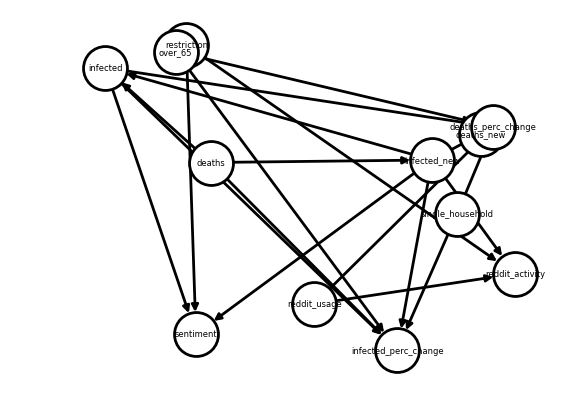

In [4]:
import matplotlib.pyplot as plt



options = {
    "font_size": 6,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}
nx.draw_networkx(graph, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
# ax.margins(0.20)
plt.axis("off")
plt.show()

## 3 - Causal Inference

###  Leave-One-Country-Out Cross Validation - Fitting the Conditional Distribution of the Bayesian Network

In [15]:
# map features to to "high" or "low"
fit_feats = discretize_df(features)

# LOCO
auc_scores = []
countries = []
for train_country_ind, test_country_ind in KFold(n_splits=cf.n_countries).split(range(cf.n_countries)):
    train_indices = cf.splits[train_country_ind]
    test_indices = cf.splits[test_country_ind]
    train_indices = list(itertools.chain.from_iterable(train_indices))
    test_indices = list(itertools.chain.from_iterable(test_indices))
    train = fit_feats.iloc[train_indices]
    test = fit_feats.iloc[test_indices]
    
    bn = train_bn(train, graph)
    # print("predictions",bn.predict(test, "reddit_activity").to_dict())

    # print(bn.predict_probability(test, "reddit_activity").to_dict())

    _, auc = roc_auc(bn, test, 'reddit_activity')
    auc_scores.append(auc)
    countries.append(cf.countries[test_country_ind[0]])
    print('Country as test = {}, AUC = {:.3f}'.format(cf.countries[test_country_ind[0]], auc))
print('\tMean AUC = {:.3f}'.format(np.mean(auc_scores)))


Country as test = Canada, AUC = 0.809
Country as test = Brazil, AUC = 0.860
Country as test = Australia, AUC = 0.845
Country as test = Japan, AUC = 0.853
Country as test = US, AUC = 1.000
Country as test = United Kingdom, AUC = 0.930
Country as test = New Zealand, AUC = 0.789
	Mean AUC = 0.870


In [16]:
fit_feats

,infected,reddit_activity,sentiment,infected_new,infected_perc_change,restriction,over_65,reddit_usage,single_household,deaths,deaths_new,deaths_perc_change
0,low,low,pos,low,low,0,high,high,high,low,low,low
1,low,low,pos,low,low,0,high,high,high,low,low,low
2,low,low,pos,low,low,0,high,high,high,low,low,low
3,low,low,pos,low,low,0,high,high,high,low,low,low
4,low,low,pos,low,low,0,high,high,high,low,low,low
5,low,low,pos,low,high,0,high,high,high,low,low,low
6,low,low,pos,low,low,0,high,high,high,low,low,low
7,low,low,pos,low,high,0,high,high,high,low,low,low
8,low,low,pos,low,low,0,high,high,high,low,low,low
9,low,low,pos,low,high,1,high,high,high,low,low,low


### Inspect Marginal Likelihoods After Observations

In [17]:
bn = BayesianNetwork(graph)
bn = bn.fit_node_states(fit_feats)
bn = bn.fit_cpds(fit_feats, method='BayesianEstimator', bayes_prior='K2')
bn.cpds['reddit_activity']

deaths_new      high                              low                     \
infected_new    high            low              high                low   
reddit_usage    high       low high       low    high       low     high   
reddit_activity                                                            
high             0.8  0.352941  0.5  0.333333  0.8125  0.136364  0.14554   
low              0.2  0.647059  0.5  0.666667  0.1875  0.863636  0.85446   

deaths_new                 
infected_new               
reddit_usage          low  
reddit_activity            
high             0.087591  
low              0.912409

#### Expected Marginal Likelihoods

##### Lower daily infections/deaths increases the probability of percentage increase being low. This is expected simply due to mathematical definition of percentage.

In [18]:
_ = marginal_probs(bn, 'deaths_perc_change', {'deaths_new': 'high'})
_ = marginal_probs(bn, 'deaths_perc_change', {'deaths_new': 'low'})

Marginal probabilities of "deaths_perc_change" | {'deaths_new': 'high'} = {'high': 0.45098080550601577, 'low': 0.5490191944939842}
Marginal probabilities of "deaths_perc_change" | {'deaths_new': 'low'} = {'high': 0.3263644104308982, 'low': 0.6736355895691019}


#### Insightful Marginal Likelihoods That Support Domain/Expert Knowledge and Literature

In [19]:
_ = marginal_probs(bn, 'infected', {'over_65': 'high'})
_ = marginal_probs(bn, 'infected', {'over_65': 'low'})


Marginal probabilities of "infected" | {'over_65': 'high'} = {'high': 0.5197262781818628, 'low': 0.4802737218181371}
Marginal probabilities of "infected" | {'over_65': 'low'} = {'high': 0.31193220541460714, 'low': 0.6880677945853929}


In [20]:
_ = marginal_probs(bn, 'deaths_perc_change', {'over_65': 'high'})
_ = marginal_probs(bn, 'deaths_perc_change', {'over_65': 'low'})

Marginal probabilities of "deaths_perc_change" | {'over_65': 'high'} = {'high': 0.2785351318759507, 'low': 0.7214648681240494}
Marginal probabilities of "deaths_perc_change" | {'over_65': 'low'} = {'high': 0.40453436793430136, 'low': 0.5954656320656987}


In [21]:
_ = marginal_probs(bn, 'sentiment', {'infected': 'high'})
_ = marginal_probs(bn, 'sentiment', {'infected': 'low'})


Marginal probabilities of "sentiment" | {'infected': 'high'} = {'neg': 0.7584072311166615, 'pos': 0.2415927688833385}
Marginal probabilities of "sentiment" | {'infected': 'low'} = {'neg': 0.5209750719966719, 'pos': 0.47902492800332813}


In [23]:
_ = marginal_probs(bn, 'deaths_new', {'single_household': 'high'})
_ = marginal_probs(bn, 'deaths_new', {'single_household': 'low'})

Marginal probabilities of "deaths_new" | {'single_household': 'high'} = {'high': 0.049875311720698264, 'low': 0.9501246882793016}
Marginal probabilities of "deaths_new" | {'single_household': 'low'} = {'high': 0.04987531172069825, 'low': 0.9501246882793016}


In [25]:
_ = marginal_probs(bn, 'deaths_perc_change', {'single_household': 'high'})
_ = marginal_probs(bn, 'deaths_perc_change', {'single_household': 'low'})


Marginal probabilities of "deaths_perc_change" | {'single_household': 'high'} = {'high': 0.2785351318759507, 'low': 0.7214648681240492}
Marginal probabilities of "deaths_perc_change" | {'single_household': 'low'} = {'high': 0.40453436793430136, 'low': 0.5954656320656987}


In [26]:
_ = marginal_probs(bn, 'infected', {'single_household': 'high', 'over_65': 'low'})
_ = marginal_probs(bn, 'infected', {'single_household': 'low',  'over_65': 'high'})


Marginal probabilities of "infected" | {'single_household': 'high', 'over_65': 'low'} = {'high': 0.31193220541460714, 'low': 0.6880677945853928}
Marginal probabilities of "infected" | {'single_household': 'low', 'over_65': 'high'} = {'high': 0.5197262781818629, 'low': 0.48027372181813716}


#### Insightful Marginal Likelihoods About Twitter Activity

In [27]:
_ = marginal_probs(bn, 'reddit_activity', {'deaths_new': 'high', 'infected_new': 'high'})
_ = marginal_probs(bn, 'reddit_activity', {'deaths_new': 'low', 'infected_new': 'low'})


Marginal probabilities of "reddit_activity" | {'deaths_new': 'high', 'infected_new': 'high'} = {'high': 0.6082440956432448, 'low': 0.3917559043567552}
Marginal probabilities of "reddit_activity" | {'deaths_new': 'low', 'infected_new': 'low'} = {'high': 0.12068411952196889, 'low': 0.8793158804780312}


In [28]:
_ = marginal_probs(bn, 'reddit_activity', {'deaths_new': 'high', 'infected_new': 'high', 'reddit_usage': 'high', 'restriction': 1})
_ = marginal_probs(bn, 'reddit_activity', {'deaths_new': 'low', 'infected_new': 'low', 'reddit_usage': 'low', 'restriction': 0})


Marginal probabilities of "reddit_activity" | {'deaths_new': 'high', 'infected_new': 'high', 'reddit_usage': 'high', 'restriction': 1} = {'high': 0.8, 'low': 0.2}
Marginal probabilities of "reddit_activity" | {'deaths_new': 'low', 'infected_new': 'low', 'reddit_usage': 'low', 'restriction': 0} = {'high': 0.0875912408759124, 'low': 0.9124087591240877}


In [29]:
_ = marginal_probs(bn, 'reddit_activity', {'restriction': 1})
_ = marginal_probs(bn, 'reddit_activity', {'restriction': 0})

Marginal probabilities of "reddit_activity" | {'restriction': 1} = {'high': 0.32688405697080175, 'low': 0.6731159430291983}
Marginal probabilities of "reddit_activity" | {'restriction': 0} = {'high': 0.3268840569708018, 'low': 0.6731159430291983}


In [30]:
_ = marginal_probs(bn, 'reddit_activity', {'reddit_usage': 'high'})
_ = marginal_probs(bn, 'reddit_activity', {'reddit_usage': 'low'})

Marginal probabilities of "reddit_activity" | {'reddit_usage': 'high'} = {'high': 0.4800734509578947, 'low': 0.5199265490421052}
Marginal probabilities of "reddit_activity" | {'reddit_usage': 'low'} = {'high': 0.1229284103251953, 'low': 0.8770715896748048}


#### Insightful Marginal Likelihoods About Overall Sentiment

In [31]:
_ = marginal_probs(bn, 'sentiment', {'deaths': 'high'})
_ = marginal_probs(bn, 'sentiment', {'deaths': 'low'})

Marginal probabilities of "sentiment" | {'deaths': 'high'} = {'neg': 0.6729205304897949, 'pos': 0.3270794695102051}
Marginal probabilities of "sentiment" | {'deaths': 'low'} = {'neg': 0.5735050722782044, 'pos': 0.4264949277217956}


In [32]:
_ = marginal_probs(bn, 'sentiment', {'deaths_new': 'high'})
_ = marginal_probs(bn, 'sentiment', {'deaths_new': 'low'})

Marginal probabilities of "sentiment" | {'deaths_new': 'high'} = {'neg': 0.6842758277087779, 'pos': 0.3157241722912222}
Marginal probabilities of "sentiment" | {'deaths_new': 'low'} = {'neg': 0.6200073931779745, 'pos': 0.3799926068220255}


In [33]:
_ = marginal_probs(bn, 'sentiment', {'deaths_new': 'high', 'deaths': 'high'})
_ = marginal_probs(bn, 'sentiment', {'deaths_new': 'low', 'deaths': 'low'})


Marginal probabilities of "sentiment" | {'deaths_new': 'high', 'deaths': 'high'} = {'neg': 0.7772568165242099, 'pos': 0.22274318347579014}
Marginal probabilities of "sentiment" | {'deaths_new': 'low', 'deaths': 'low'} = {'neg': 0.5725712262616616, 'pos': 0.4274287737383385}


In [34]:
_ = marginal_probs(bn, 'sentiment', {'restriction': 1})
_ = marginal_probs(bn, 'sentiment', {'restriction': 0})


Marginal probabilities of "sentiment" | {'restriction': 1} = {'neg': 0.7194937528839155, 'pos': 0.2805062471160846}
Marginal probabilities of "sentiment" | {'restriction': 0} = {'neg': 0.427003892645535, 'pos': 0.5729961073544649}
